In [1]:
import numpy as np
import random
import math
from tqdm.notebook import tqdm
import pandas as pd
import torch
import torch.nn.functional as F
from gym import spaces
import matplotlib.pyplot as plt
from dataclasses import dataclass
from env import *
from SAC import *

/Users/valentinbrekke/miniconda3/lib/python3.10/site-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


In [2]:
env_param = dict(a=0.5, 
                T=10, 
                k=0.1, 
                Ux=1, 
                Uy=1, 
                alpha=1, 
                sigma=0.1, 
                x_goal=4, 
                y_goal=4, 
                pos0=np.array([0, 0, 0]), 
                theta0=0, 
                dist_threshold=0.2, 
                max_steps=200,
                ocean=True,
                dt=1,
                max_thrust_speed=5,
                )

env = FluidMechanicsEnv(**env_param)

/Users/valentinbrekke/miniconda3/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [3]:
@dataclass
class Args:
    
    seed: int = 1
    """seed of the experiment"""
    torch_deterministic: bool = True
    """if toggled, `torch.backends.cudnn.deterministic=False`"""
    cuda: bool = True
    """if toggled, cuda will be enabled by default"""
    # Algorithm specific arguments
    total_timesteps: int = 100000
    """total timesteps of the experiments"""
    buffer_size: int = int(1e6)
    """the replay memory buffer size"""
    gamma: float = 0.99
    """the discount factor gamma"""
    tau: float = 0.005
    """target smoothing coefficient (default: 0.005)"""
    batch_size: int = 256
    """the batch size of sample from the reply memory"""
    learning_starts: int = 25000
    """timestep to start learning"""
    policy_lr: float = 3e-4
    """the learning rate of the policy network optimizer"""
    q_lr: float = 1e-3
    """the learning rate of the Q network network optimizer"""
    policy_frequency: int = 2
    """the frequency of training policy (delayed)"""
    target_network_frequency: int = 1  # Denis Yarats' implementation delays this by 2.
    """the frequency of updates for the target nerworks"""
    alpha: float = 0.2
    """Entropy regularization coefficient."""
    autotune: bool = True
    """automatic tuning of the entropy coefficient"""
    print_reward: bool = True
    """print the smooth reward after each epoch during training"""

## Base framework

In [5]:

# Seed everything for reproducibility
args = Args()
args.print_reward = True
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.backends.cudnn.deterministic = args.torch_deterministic

# Create and train SAC agent
sac_agent = SAC(env, args)

policy, t, episode_num, smooth_reward, execution_time = sac_agent.train()


KeyboardInterrupt: 

In [4]:
def plot_trajectory(policy):
    done = False
    obs = env.reset()
    x, y = [obs[0]], [obs[1]]

    while not done: 
        actions, _, _ = policy.get_action(torch.Tensor(obs).unsqueeze(0))
        actions = actions.detach().cpu().numpy()
        next_obs, rewards, sum_reward, terminations, steps_count, all_actions, = env.step(actions[0])
        x.append(next_obs[0])
        y.append(next_obs[1])
        obs = next_obs
        done = terminations
       
    fig = plt.figure(figsize = (10, 5))
    plt.grid(True)
    plt.scatter([env.x_goal], [env.y_goal], marker = "o", color = "r")
    plt.plot(x, y, 'k-o')
    plt.show()

def plot_reward(smooth_reward):
    # Plot cumulative rewards
    plt.figure(figsize=(10, 5))
    plt.plot(smooth_reward)
    plt.title("SAC - Cumulative Rewards Over Episodes")
    plt.xlabel("Episodes")
    plt.ylabel("Cumulative Reward")
    plt.grid(True)
    plt.show()

In [6]:
plot_reward(smooth_reward)

NameError: name 'smooth_reward' is not defined

In [ ]:
plot_trajectory(policy)

NameError: name 'policy' is not defined

## Run multiple instance with seeds

In [38]:
env_param = dict(a=0.5, 
                T=2, 
                k=0.1, 
                Ux=-0.1, 
                Uy=-0.5, 
                alpha=1, 
                sigma=0.1, 
                x_goal=4, 
                y_goal=4, 
                pos0=np.array([0, 0, 0]), 
                theta0=0, 
                dist_threshold=0.2, 
                max_steps=200,
                ocean=True,
                dt=1,
                max_thrust_speed=5,
                )

env = FluidMechanicsEnv(**env_param)

/Users/valentinbrekke/miniconda3/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [40]:
env.wind.Ux

-0.1

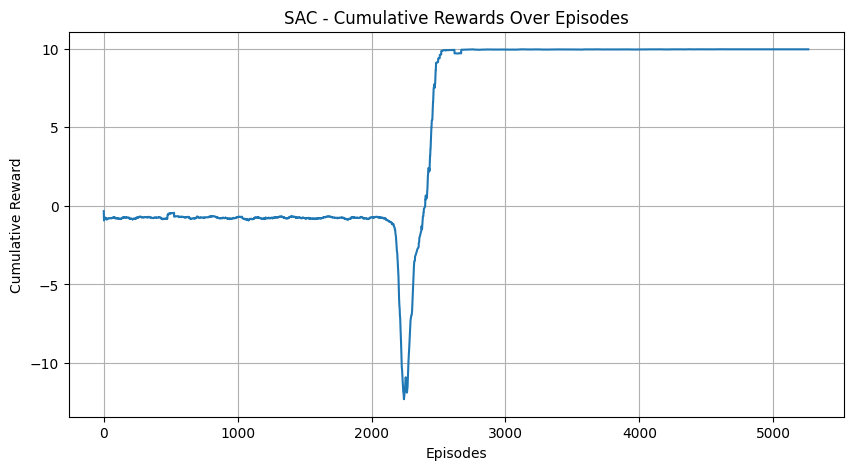

In [41]:
import json

reward_dict = dict()
#### Train and save the actor model
for seed in range(1):
        # Seed everything for reproducibility
        args = Args()
        args.seed = seed
        args.print_reward = False
        random.seed(args.seed)
        np.random.seed(args.seed)
        torch.manual_seed(args.seed)
        if args.cuda:
                torch.backends.cudnn.deterministic = args.torch_deterministic

        # Create and train SAC agent
        sac_agent = SAC(env, args)
        model, t, episode_num, smooth_reward, execution_time = sac_agent.train()

        #print(f"seed: {seed}, Total steps: {t}, Num episodes: {episode_num}, execution_time : {execution_time}")
        reward_dict[seed] = smooth_reward
         
        if seed == 0:
                torch.save(model.state_dict(), "saved/SAC_seed0_wind_other_side.pth")

        # #### Plot smooth reward
        plot_reward(smooth_reward)

        #### Sample a trajectory 
        # trajectory, total_reward = sample_trajectory(env, policy, env.max_steps)
        # print("Total reward from sampled trajectory:", total_reward)
        # plot_trajectory(trajectory)
#with open('saved/SAC_5.txt', 'w') as convert_file: 
#    convert_file.write(json.dumps(reward_dict))

In [48]:
def get_trajectory(model):
    done = False
    obs = env.reset()
    x, y = [obs[0]], [obs[1]]

    while not done: 
        actions, _, _ = model.get_action(torch.Tensor(obs).unsqueeze(0))
        actions = actions.detach().cpu().numpy()
        next_obs, rewards, sum_reward, terminations, steps_count, all_actions, = env.step(actions[0])
        x.append(next_obs[0])
        y.append(next_obs[1])
        obs = next_obs
        done = terminations
       
    return x, y

In [77]:
x, y = get_trajectory(model)
x, y

([0.0,
  -0.2667952991266148,
  0.04036023512835679,
  1.6679770771023914,
  3.9096802443000227],
 [0.0,
  -0.44578646316856185,
  -0.9269745907867077,
  1.2546653769083507,
  4.0164055533812855])

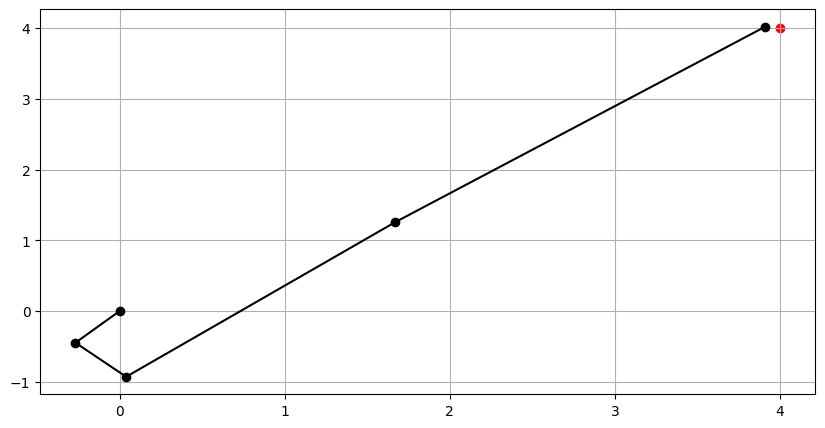

In [78]:
fig = plt.figure(figsize = (10, 5))
plt.grid(True)
plt.scatter([env.x_goal], [env.y_goal], marker = "o", color = "r")
plt.plot(x, y, 'k-o')
plt.show()

In [83]:
def count_mean_rewards(model, n=100):
    average = 0
    for k in range(n):
        done = False
        obs = env.reset()

        while not done: 
            actions, _, _ = model.get_action(torch.Tensor(obs).unsqueeze(0))
            actions = actions.detach().cpu().numpy()
            next_obs, rewards, sum_reward, terminations, steps_count, all_actions, = env.step(actions[0])
            obs = next_obs
            done = terminations
          
        average += sum_reward
          
    return average/n

In [87]:
count_mean_rewards(model, n=100)

9.967774456026609

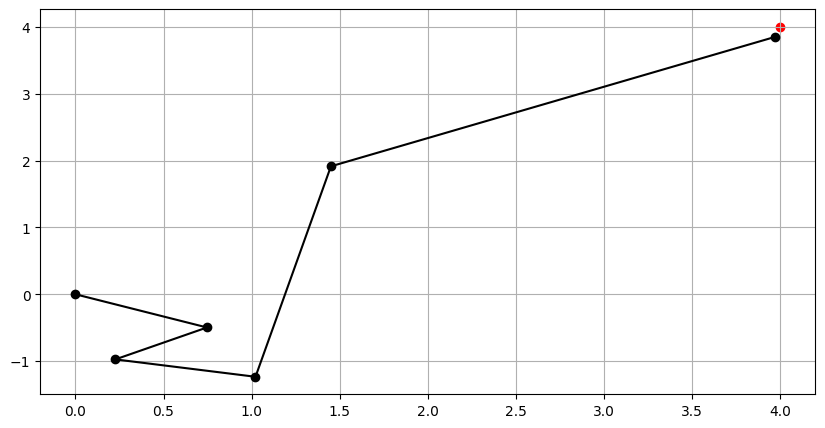

In [71]:
plot_trajectory(model)

## Load pretrained and stored actor

In [23]:
env.wave.a

0.5

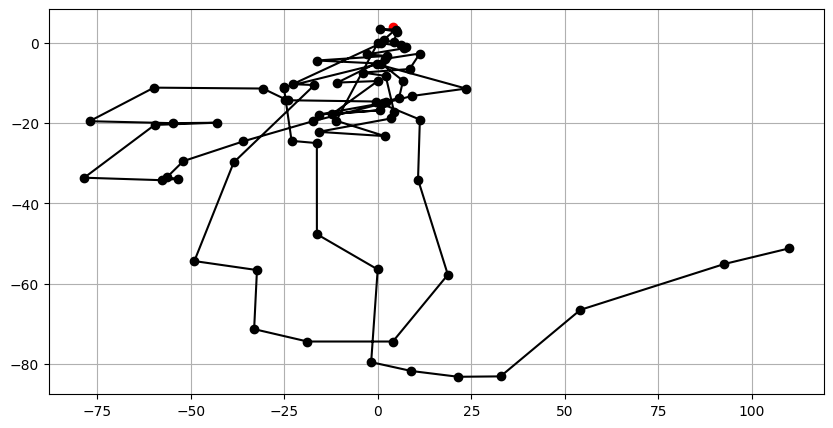

In [35]:
#### Load the actor model 
env.x_goal=4
env.y_goal = 4
env.wave.a = 5
env.wind.Ux= 1
policy = Actor(env)
policy.load_state_dict(torch.load("saved/SAC_seed0_wave5.pth"))
plot_trajectory(policy)

## steps to converge with size of waves

In [4]:
waves = np.arange(0, 5.5, 0.5)

args = Args()
args.print_reward = False
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.backends.cudnn.deterministic = args.torch_deterministic

result = {}
for wave in waves: 
    env.wave.a = wave
    sac_agent = SAC(env, args)
    step = sac_agent.train()
    result[wave] = step

for wave.a = 0.0: nbr of episode to convergence 76007


for wave.a = 0.5: nbr of episode to convergence 84630


for wave.a = 1.0: nbr of episode to convergence 88309


for wave.a = 1.5: nbr of episode to convergence 85377


for wave.a = 2.0: nbr of episode to convergence 85705


for wave.a = 2.5: nbr of episode to convergence 93212


for wave.a = 3.0: nbr of episode to convergence 92851


for wave.a = 3.5: nbr of episode to convergence 87894


for wave.a = 4.0: nbr of episode to convergence 86344


for wave.a = 4.5: nbr of episode to convergence 83923


for wave.a = 5.0: nbr of episode to convergence 91085




In [48]:
result

{0.0: (Actor(
    (fc1): Linear(in_features=9, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc_mean): Linear(in_features=256, out_features=2, bias=True)
    (fc_logstd): Linear(in_features=256, out_features=2, bias=True)
  ),
  100000,
  6475,
  [-0.903821417822045,
   -0.8685437748978362,
   -0.8054561494768541,
   -0.6961573800537326,
   -0.6489140895599188,
   -0.7526554208130577,
   -0.8128179944752053,
   -0.7693448451447684,
   -0.7381113408198432,
   -0.7155338645681264,
   -0.7365751506288714,
   -0.7383790105957478,
   -0.7129891710938703,
   -0.7373066244460006,
   -0.7213936650129064,
   -0.738459840986683,
   -0.7192994651722995,
   -0.7201524086801989,
   -0.7844342408512334,
   -0.7992265706674544,
   -0.8322222445543576,
   -0.821073696899361,
   -0.8054678511237909,
   -0.8150176557681063,
   -0.8043620683754708,
   -0.7903444469846677,
   -0.7773987311916353,
   -0.7963955888417216,
   -0.8076330753568722,
   -0.7973

## For martin

In [ ]:
env_param = dict(a=0, 
                T=10, 
                k=0.1, 
                Ux=1, 
                Uy=1, 
                alpha=1, 
                sigma=0.1, 
                x_goal=4, 
                y_goal=4, 
                pos0=np.array([0, 0, 0]), 
                theta0=0, 
                dist_threshold=0.2, 
                max_steps=200,
                ocean=True,
                dt=1,
                max_thrust_speed=5,
                )

env = FluidMechanicsEnv(**env_param)

In [ ]:
LOG_STD_MAX = 2
LOG_STD_MIN = -5

class Actor(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.prod(env.observation_space.shape), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mean = nn.Linear(256, np.prod(env.action_space.shape))
        self.fc_logstd = nn.Linear(256, np.prod(env.action_space.shape))
        # action rescaling
        self.register_buffer(
            "action_scale", torch.tensor((env.action_space.high - env.action_space.low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((env.action_space.high + env.action_space.low) / 2.0, dtype=torch.float32)
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        log_std = LOG_STD_MIN + 0.5 * (LOG_STD_MAX - LOG_STD_MIN) * (log_std + 1)  # From SpinUp / Denis Yarats

        return mean, log_std

    def get_action(self, x):
        mean, log_std = self(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6)
        log_prob = log_prob.sum(-1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean

In [ ]:
#### Load the actor model 
policy = Actor(env)
policy.load_state_dict(torch.load("saved/SAC_seed0_wave5.pth"))

## Run and plot trajectory
done = False
obs = env.reset()
env.theta0 = 0
x, y = [obs[0]], [obs[1]]
while not done: 
    actions, _, _ = policy.get_action(torch.Tensor(obs).unsqueeze(0))
    actions = actions.detach().cpu().numpy()
    next_obs, rewards, sum_reward, terminations, steps_count, all_actions, = env.step(actions[0])
    x.append(next_obs[0])
    y.append(next_obs[1])
    obs = next_obs
    done = terminations
    
fig = plt.figure(figsize = (10, 5))
plt.grid(True)
plt.scatter([env.x_goal], [env.y_goal], marker = "o", color = "r")
plt.plot(x, y, 'k-o')
plt.show()